<a href="https://colab.research.google.com/github/ShinyRyo/siganate-COVID-19-Challenge/blob/corna_corpus/eda_prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#データの取得
Githubからデータを持ってくる

In [0]:
!git clone https://<githubのid>:<githubのパスワード>@github.com/<githubのid>/<githubのリポジトリ名>.git

Cloning into 'siganate-COVID-19-Challenge'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


In [4]:
 # Load Basic Libraries
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, save
import plotly.graph_objects as go
import sklearn
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.plotting.register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
pip install xlrd

In [6]:
train_df=pd.read_excel('siganate-COVID-19-Challenge/input/SIGNATE COVID-19 Case Dataset.xlsx', sheet_name='罹患者')
train_df
#test_df=pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')
#all_data=pd.concat([train_df,test_df],axis=0) # combined train and test data
#all_data.reset_index(drop=True) # reset index with drop true

,ID,厚労省コード,都道府県症例番号,発症日,確定日,公表日,全国地方公共団体コード,受診都道府県,管理市区町村,居住都道府県,居住市区町村,年代,性別,職業,医療従事者ﾌﾗｸﾞ,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源1,情報源2,備考,Unnamed: 28,Unnamed: 29,都道府県コード,都道府県症例番号.1
0,1,NaN,1-1,2020-01-26,NaT,2020-01-28,NaN,神奈川県,NaN,NaN,NaN,40 - 49,女性,NaN,NaN,NaN,0.0,NaN,2020/01/21に来日し、2020/01/22より北海道を観光。\n2020/01/26...,NaN,2020/01/21、２名で来日し東京都内の知人宅に宿泊。\n2020/01/22、３名で東...,濃厚接触者を特定し\n健康観察終了,NaN,1,0.0,http://www.pref.hokkaido.lg.jp/hf/kth/kak/hass...,NaN,NaN,NaN,NaN,1,1
1,2,NaN,1-2,2020-01-31,2020-02-14,2020-02-14,NaN,北海道,NaN,北海道,札幌市,50 - 59,男性,自営業,NaN,NaN,0.0,NaN,2020/01/31 発熱、咳、倦怠感が出現。\n2020/02/03 石狩振興局管内の医療...,NaN,海外渡航歴なし。濃厚接触者は、現時点で家族、同僚等43名を特定し、健康観察実施中。,NaN,NaN,0,0.0,http://www.pref.hokkaido.lg.jp/hf/kth/kak/hass...,NaN,NaN,NaN,NaN,1,2
2,3,63,1-3,2020-02-08,2020-02-18,2020-02-19,NaN,北海道,NaN,北海道,札幌市,40 - 49,男性,会社員,NaN,NaN,0.0,NaN,2020/2/8 倦怠感、筋肉痛、関節痛が出現\n2020/2/12 発熱、咳が出現\n20...,NaN,2020/2/1から2020/2/12までの期間、No.5の男性(2020/2/19感染判明...,札幌市公表中\nid:1-5,NaN,0,0.0,http://www.pref.hokkaido.lg.jp/hf/kth/kak/hass...,http://www.pref.hokkaido.lg.jp/hf/kth/kak/hass...,NaN,NaN,NaN,1,3
3,4,64,1-4,2020-02-03,2020-02-19,2020-02-19,NaN,北海道,NaN,北海道,七飯町,60 - 69,男性,議会議員,NaN,NaN,0.0,NaN,2020/2/3 微熱、咽頭痛。\n2020/2/7 渡島総合振興局管内の医療機関Aを受診。...,NaN,本人からの申告によれば、海外渡航歴は無し。\n濃厚接触者48名について保健所が健康観察を行う...,濃厚接触者を特定し健康観察終了\nid:1-12,NaN,0,0.0,http://www.pref.hokkaido.lg.jp/hf/kth/kak/hass...,http://www.pref.hokkaido.lg.jp/hf/kth/kak/sing...,NaN,NaN,NaN,1,4
4,5,72,1-5,2020-02-15,2020-02-19,2020-02-20,NaN,北海道,NaN,北海道,札幌市,40 - 49,男性,会社員,NaN,NaN,0.0,NaN,2020/2/15 悪寒、発汗、倦怠感、筋肉痛、関節痛が出現。\n2020/2/18 発熱、...,NaN,2020/2/1から2020/2/12までの期間、id:1-3の男性(2020/2/18感染...,札幌市公表中\nid:1-3,NaN,0,0.0,http://www.pref.hokkaido.lg.jp/hf/kth/kak/hass...,http://www.pref.hokkaido.lg.jp/hf/kth/kak/hass...,NaN,NaN,NaN,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7692,7695,NaN,17-125,NaT,NaT,NaT,NaN,石川県,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,125
7693,7696,NaN,17-126,NaT,NaT,NaT,NaN,石川県,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,126
7694,7697,NaN,17-127,NaT,NaT,NaT,NaN,石川県,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,127
7695,7698,NaN,17-128,NaT,NaT,NaT,NaN,石川県,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,128


In [7]:
train_df.columns

Index(['ID', '厚労省コード', '都道府県症例番号', '発症日', '確定日', '公表日', '全国地方公共団体コード',
       '受診都道府県', '管理市区町村', '居住都道府県', '居住市区町村', '年代', '性別', '職業', '医療従事者ﾌﾗｸﾞ',
       'ステータス', '退院済ﾌﾗｸﾞ', '基礎疾患ﾌﾗｸﾞ', '症状・経過', '症状一覧', '行動歴', '濃厚接触者状況',
       '濃厚接触場所', '海外渡航歴ﾌﾗｸﾞ', 'ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ', '情報源1', '情報源2', '備考',
       'Unnamed: 28', 'Unnamed: 29', '都道府県コード', '都道府県症例番号.1'],
      dtype='object')

##非構造化データの取得

In [0]:
pd.set_option('display.max_rows', 10)

In [10]:
train_df[['ID','発症日', '症状・経過', '症状一覧', '行動歴', '濃厚接触者状況',]]

,ID,発症日,症状・経過,症状一覧,行動歴,濃厚接触者状況
0,1,2020-01-26,2020/01/21に来日し、2020/01/22より北海道を観光。\n2020/01/26...,NaN,2020/01/21、２名で来日し東京都内の知人宅に宿泊。\n2020/01/22、３名で東...,濃厚接触者を特定し\n健康観察終了
1,2,2020-01-31,2020/01/31 発熱、咳、倦怠感が出現。\n2020/02/03 石狩振興局管内の医療...,NaN,海外渡航歴なし。濃厚接触者は、現時点で家族、同僚等43名を特定し、健康観察実施中。,NaN
2,3,2020-02-08,2020/2/8 倦怠感、筋肉痛、関節痛が出現\n2020/2/12 発熱、咳が出現\n20...,NaN,2020/2/1から2020/2/12までの期間、No.5の男性(2020/2/19感染判明...,札幌市公表中\nid:1-5
3,4,2020-02-03,2020/2/3 微熱、咽頭痛。\n2020/2/7 渡島総合振興局管内の医療機関Aを受診。...,NaN,本人からの申告によれば、海外渡航歴は無し。\n濃厚接触者48名について保健所が健康観察を行う...,濃厚接触者を特定し健康観察終了\nid:1-12
4,5,2020-02-15,2020/2/15 悪寒、発汗、倦怠感、筋肉痛、関節痛が出現。\n2020/2/18 発熱、...,NaN,2020/2/1から2020/2/12までの期間、id:1-3の男性(2020/2/18感染...,札幌市公表中\nid:1-3
...,...,...,...,...,...,...
7692,7695,NaT,NaN,NaN,NaN,NaN
7693,7696,NaT,NaN,NaN,NaN,NaN
7694,7697,NaT,NaN,NaN,NaN,NaN
7695,7698,NaT,NaN,NaN,NaN,NaN


#コーパスの作成

##コーパスの環境構築

In [11]:
#mecabを使えるようにするためのライブラリ
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp

In [12]:
#neologdはcontentに入れる
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-NEologd] :     diff => ok
[install-mecab-ipadic-NEologd] :   

In [0]:
import numpy as np
import pandas as pd
import pickle
from gensim.models import word2vec
import MeCab

In [0]:
import subprocess

cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neo = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
tagger=MeCab.Tagger("-d {0}".format(path_neo))#タグはMeCab.Tagger（neologd辞書）を使用

#コーパス作成

In [0]:
tagger.parse('')
def tokenize_ja(text, lower):
    node = tagger.parseToNode(str(text))
    while node:
        if lower and node.feature.split(',')[0] in ["名詞","形容詞"]:#分かち書きで取得する品詞を指定
            yield node.feature.split(",")[6].lower() #原型を保存。元は=>node.surface.lower()
        node = node.next
def tokenize(content, token_min_len, token_max_len, lower):
    return [
        str(token) for token in tokenize_ja(content, lower)
        if token_min_len <= len(token) <= token_max_len and not token.startswith('_')
    ]

In [0]:
corpus_df = train_df[['症状・経過', '症状一覧', '行動歴', '濃厚接触者状況',]]

In [0]:
#コーパス作成
wakati_corna_text = []
for i in corpus_df['症状・経過'].dropna():
    txt = tokenize(i, 1, 10000, True)
    wakati_corna_text.append(txt)

In [0]:
np.savetxt("corna_corpus.txt", wakati_corna_text,fmt='%s', delimiter=',')

In [0]:
word2vec_corna_model = word2vec.Word2Vec(wakati_corna_text,sg=1,size=100, window=5,min_count=5,iter=100,workers=3)

In [0]:
# モデルのセーブ
word2vec_corna_model.save("word2vec_corna_model.model")

In [21]:
# モデルのロード
word2vec_corna_model =word2vec.Word2Vec.load("word2vec_corna_model.model")
word2vec_corna_model.most_similar("感染")

[('疑似', 0.45049405097961426),
 ('岐阜県', 0.44998013973236084),
 ('在住', 0.3919996917247772),
 ('障害', 0.37564119696617126),
 ('娘。', 0.3543801009654999),
 ('濃厚接触', 0.35176730155944824),
 ('職員', 0.3488585650920868),
 ('指示', 0.3462025821208954),
 ('那覇市', 0.33857178688049316),
 ('医師', 0.3346438705921173)]

#言葉の使われ方を6つに分ける

In [0]:
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from sklearn.cluster import KMeans

model = KeyedVectors.load('word2vec_corna_model.model')

max_vocab = 30000 #40000にしても結果は同じだった
vocab = list(model.wv.vocab.keys())[:max_vocab]
vectors = [model.wv[word] for word in vocab]

n_clusters = 6 #クラスター数はこちらで任意の値を定める
kmeans_model = KMeans(n_clusters=n_clusters, verbose=0, random_state=42, n_jobs=-1)
kmeans_model.fit(vectors)

cluster_labels = kmeans_model.labels_
cluster_to_words = defaultdict(list)
for cluster_id, word in zip(cluster_labels, vocab):
    cluster_to_words[cluster_id].append(word)

In [43]:
for i, words in zip(cluster_to_words.keys(), cluster_to_words.values()):
    print(i, words[:20])

症状に関する大まかなワード ['*', '咳', '発熱', '医療機関', '受診', '倦怠感', '出現', '症状', '呼吸', '継続', '感冒', '異常', '保健所', '相談', '自宅待機', '微熱', '台', '痰', '連絡', '回復']
コロナに起因する行動に関するワード ['来日', '外出', '夜間', '熱', '筋肉痛', '関節痛', '利用', '薬', 'ない', '咽頭痛', '悪寒', '帰宅', '以降', '早退', '不明', '体温', '定期', '呼吸器', '感', '喉']
イベント発生場所に関するワード ['体調不良', 'ため', '胸部', 'レントゲン', '肺炎', '像', '上', '紹介', '治療', '改善', 'ct', '両側', '服薬', 'インフルエンザ', '陰性', '同日', '指示', 'x線', '病院', '傾向']
症状に関する詳細なワード ['入院', '検査', '安定', '管内', '開始', '状態', 'icu', '人工呼吸器', '管理', '札幌市', '衛生研究所', '新型コロナウイルス', '実施', 'ところ', '陽性', '判明', '感染症', '指定', '市立札幌病院', '現在']
日付に関するワード ['容態', '内', '困難', '2月22日', '2月23日', '2月26日', '2月28日', '3月2日', '3月4日', '3月1日', '3月3日', '3月5日', '3月6日', '2月27日', '2月29日', '2月21日', '2月25日', '3月7日', '3月8日', '3月9日']
感染経路に関するワード ['患者', '病棟', '時点', '−1', '濃厚接触', '健康観察', '−4', '土曜日', '金曜日', '木曜日', '勤務先', '例', '目', '同居', '家族', '方', '発生', '妻', '友人', '父親']


In [52]:
model.wv.vocab.keys()#cluster_labelsと相関

dict_keys(['*', '来日', '体調不良', 'ため', '外出', '夜間', '咳', '発熱', '医療機関', '受診', '入院', '胸部', 'レントゲン', '検査', '肺炎', '像', '熱', '容態', '安定', '倦怠感', '出現', '管内', '上', '紹介', '治療', '開始', '症状', '改善', 'ct', '両側', '呼吸', '状態', 'icu', '人工呼吸器', '管理', '札幌市', '衛生研究所', '新型コロナウイルス', '実施', 'ところ', '陽性', '判明', '感染症', '指定', '市立札幌病院', '現在', '継続', '中', '筋肉痛', '関節痛', '利用', '感冒', '薬', '服薬', 'インフルエンザ', '陰性', '異常', 'ない', '同日', '保健所', '相談', '検体', '採取', '自宅待機', '指示', '微熱', '咽頭痛', '台', 'x線', '道立', '悪寒', '痰', '帰宅', '連絡', '患者', '探知', '病院', '内', '病棟', '回復', '傾向', '以降', '早退', '自宅療養', '苦', '未明', '死亡', '確認', '所見', '全身', '発症', '不明', '体温', '定期', '時点', '呼吸器', 'c，t', '症', '判断', '倦怠', '感', '頭痛', '強い', '喉', '風邪薬', '処方', '肺', '後', '夜', '0度', '発現', '市内', '抗生剤', '投与', '悪化', '検査結果', 'こと', '状況', '程度', '鼻汁', '−1', '濃厚接触', '者', '以外', '搬送', '調整中', '退院', '救急搬送', '装着', '自家用車', '検体採取', '鼻水', '吐き気', '軽度', '深夜', '救急', 'センター', '電話相談', '画像', '頭', '痛', '明らか', '陰影', '解熱剤', '等', '依頼', '基礎', '疾患', '頃', '新型コロナウィルス', '健康観察', '37.2度', 'm', '37度', '午前中', '軽症'

In [0]:
vocab

In [51]:
cluster_to_words.values()

dict_values([['*', '咳', '発熱', '医療機関', '受診', '倦怠感', '出現', '症状', '呼吸', '継続', '感冒', '異常', '保健所', '相談', '自宅待機', '微熱', '台', '痰', '連絡', '回復', '自宅療養', '苦', '全身', '発症', '倦怠', '頭痛', '強い', '後', '発現', '市内', '抗生剤', '検査結果', '鼻汁', '者', '検体採取', '鼻水', 'センター', '電話相談', '頭', '痛', '等', '頃', '呼吸困難', '有理', '市外', '下痢', '鼻', 'g', '3/3', '食欲低下', '解熱', 'その後', '増強', '様子', '関節', '胸', '痛み', '胸痛', '腰痛', '木', '金', '土', '月', '火', '水', '帰国者', '接触', '外来', '日', '本人', '夜中', '持続', '3月', '3月25日', '3月26日', '3月27日', '3月28日', '3月29日', '味覚障害', '嗅覚障害', '通', '4/3', '3月31日', '4月1日', '4月3日', '3月30日', '新型', '一', '37℃', '味覚', '4月2日', '4月', '嗅覚', '6日', '4日', '7日', '眩暈', '1日', '東京', '健康', '的', '県内', '電話', 'さ', 'お呼び', '30日', '時', '31日', '診断', '息苦しい', '再々', '気管支炎', '自覚', '１', '２', '夕方', '９', '３', '４', 'コロナ', '往診', '節々', '６', '５', '８', '７', 'ウイルス検査', '30分', '度', '医療', '機関', '０', 'かかりつけ医', '診療所', '医', '市', '福祉センター', '夫', 'これ', '宅', '味', '軽快', '翌日', '39.1度', '苦しい', '36.2度', '体', '．', '設置', '会社', '上昇', '福祉事務所', '福井市', '丹南', '奥越', '松本', '主',

In [0]:
def change_dict_key(d, old_key, new_key, default_value=None):
    d[new_key] = d.pop(old_key, default_value)
change_dict_key(cluster_to_words, 5, '症状に関する大まかなワード')
change_dict_key(cluster_to_words, 4, 'コロナに起因する行動に関するワード')
change_dict_key(cluster_to_words, 3, 'イベント発生場所に関するワード')
change_dict_key(cluster_to_words, 2,  '症状に関する詳細なワード')
change_dict_key(cluster_to_words, 0, '日付に関するワード')
change_dict_key(cluster_to_words, 1, '感染経路に関するワード')

df_dict = pd.DataFrame.from_dict(cluster_to_words, orient="index").T

In [33]:
df_dict[:20]

,症状に関する大まかなワード,コロナに起因する行動に関するワード,イベント発生場所に関するワード,症状に関する詳細なワード,日付に関するワード,感染経路に関するワード
0,*,来日,体調不良,入院,容態,患者
1,咳,外出,ため,検査,内,病棟
2,発熱,夜間,胸部,安定,困難,時点
3,医療機関,熱,レントゲン,管内,2月22日,−1
4,受診,筋肉痛,肺炎,開始,2月23日,濃厚接触
...,...,...,...,...,...,...
15,微熱,体温,同日,判明,2月21日,方
16,台,定期,指示,感染症,2月25日,発生
17,痰,呼吸器,x線,指定,3月7日,妻
18,連絡,感,病院,市立札幌病院,3月8日,友人


In [0]:
model["医療機関"]

#クラスターの可視化

In [0]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [0]:
df = pd.DataFrame(vectors)
df["word"] = vocab#vocab
df["cluster"] = cluster_labels#数字を使いたい

In [0]:
#PCAで2次元に圧縮
pca = PCA(n_components=2)
pca.fit(df.iloc[:,:-2])
feature = pca.transform(df.iloc[:,:-2])

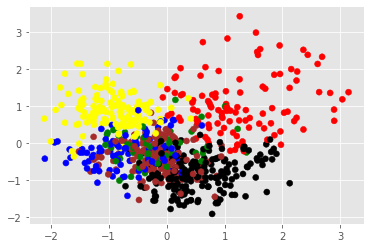

In [69]:
#可視化
plt.scatter(feature[:,0], feature[:,1], color=colors)
plt.show()

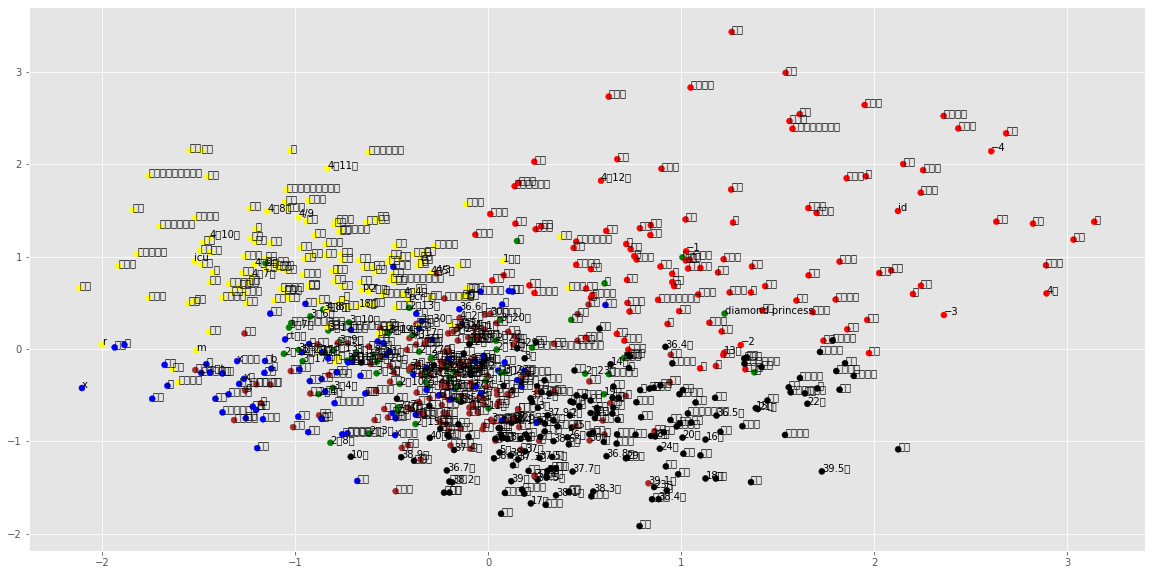

In [68]:
#散布図プロット
#fp = FontProperties(fname=r"NotoSansCJKjp-Black.otf")
color = {0:"green",1:"red",2:"yellow",3:"blue",4:"black",5:"brown"}
colors = [color[x] for x in cluster_labels]
plt.figure(figsize=(20,10))
for x, y, name in zip(feature[:, 0], feature[:, 1], df.iloc[:, -2]):
    plt.text(x, y, name)
plt.scatter(feature[:,0],feature[:,1],color=colors)
plt.show()

In [41]:
model.corpus_count

2981

In [0]:
dir(model)

In [0]:
pivot=pd.pivot_table(train_df,columns='Country_Region',
                     index='Date',
                     values='ConfirmedCases',
                     aggfunc=np.sum)

pivot_fatality=pd.pivot_table(train_df,
                              columns='Country_Region',
                              index='Date',
                              values='Fatalities',
                              aggfunc=np.sum)
country_list=[]
value_list=[]
fatality_list=[]

for country in list(pivot.columns):
    country_list.append(country)
    value_list.append(pivot[country].max())
    fatality_list.append(pivot_fatality[country].max())
    new_dict={'Country':country_list,'Confirmed':value_list,'Fatality':fatality_list}

df=pd.DataFrame.from_dict(new_dict)
df.set_index('Country',inplace=True)
df

,Confirmed,Fatality
Country,,
Afghanistan,521.0,15.0
Albania,416.0,23.0
Algeria,1761.0,256.0
Andorra,601.0,26.0
Angola,19.0,2.0
...,...,...
Vietnam,257.0,0.0
West Bank and Gaza,267.0,2.0
Western Sahara,4.0,0.0


In [0]:
sortdf_conf = df.sort_values(by=['Confirmed'],ascending=False)
sortdf_fat = df.sort_values(by=['Fatality'],ascending=False)
top10_conf = sortdf_conf.head(10)
top10_fat = sortdf_fat.head(10)
print(top10_conf)
print(top10_fat)

                Confirmed  Fatality
Country                            
US               496372.0   18581.0
Spain            158273.0   16081.0
Italy            147577.0   18849.0
France           125931.0   13215.0
Germany          122171.0    2767.0
China             82941.0    3340.0
United Kingdom    74605.0    8974.0
Iran              68192.0    4232.0
Turkey            47029.0    1006.0
Belgium           26667.0    3019.0
                Confirmed  Fatality
Country                            
Italy            147577.0   18849.0
US               496372.0   18581.0
Spain            158273.0   16081.0
France           125931.0   13215.0
United Kingdom    74605.0    8974.0
Iran              68192.0    4232.0
China             82941.0    3340.0
Belgium           26667.0    3019.0
Germany          122171.0    2767.0
Netherlands       23249.0    2520.0


In [0]:
# Confirmed COVID-19 Cases by country
import plotly.express as px
fig = px.bar(top10_conf, x=top10_conf.index, y='Confirmed', 
             labels={'x':'Country'}, color="Confirmed", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Top 10 Confirmed COVID-19 cases by country')
fig.show()

fig = px.bar(top10_fat, x=top10_fat.index, y='Fatality', 
             labels={'x':'Country'}, color="Fatality", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Top 10 Fatality COVID-19 cases by country')
fig.show()

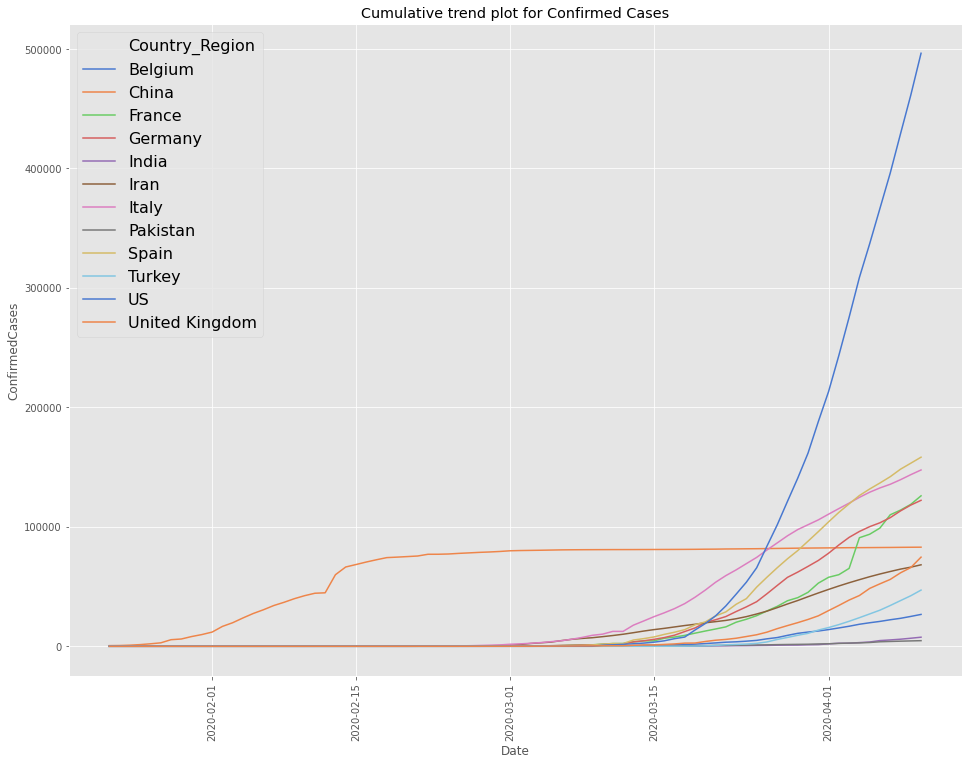

In [0]:
# We can also sort values using this code
top_confirmed=df.sort_values(by='Confirmed',ascending=False)[:10]
top_confirmed

# Make List of Top 10 Countries and India and Pakistan- The Countries of interest.
list_countries=list(top_confirmed.index)
list_countries.append('India')
list_countries.append('Pakistan')


times_series_cntr = train_df.groupby(['Date','Country_Region'])['ConfirmedCases'].sum()\
                    .reset_index().set_index('Date')
df_countries_tm = times_series_cntr[times_series_cntr['Country_Region'].isin(list_countries)]


plt.figure(figsize=(16,12))
ax = sns.lineplot(x=df_countries_tm.index, 
                  y="ConfirmedCases", 
                  hue="Country_Region", 
                  data=df_countries_tm,palette='muted').set_title('Cumulative line')

plt.legend(loc=2, prop={'size': 16})
plt.title('Cumulative trend plot for Confirmed Cases')
plt.xticks(rotation=90);

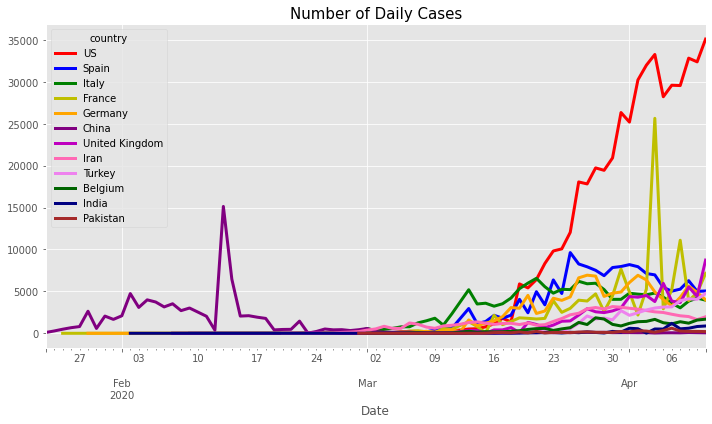

In [0]:
Confirm_pivot=pd.pivot_table(train_df,index='Date',columns='Country_Region',
                             values='ConfirmedCases',aggfunc=np.sum)
Confirm_pivot

plt.figure(figsize=(10,6))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Confirm=Confirm_pivot[Confirm_pivot[country]>0][country].diff().fillna(0)
    Confirm=Confirm[Confirm>0]
    Confirm.plot(color=colors[i],label=country,markersize=8,lw=3)   
    plt.title('Number of Daily Cases',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

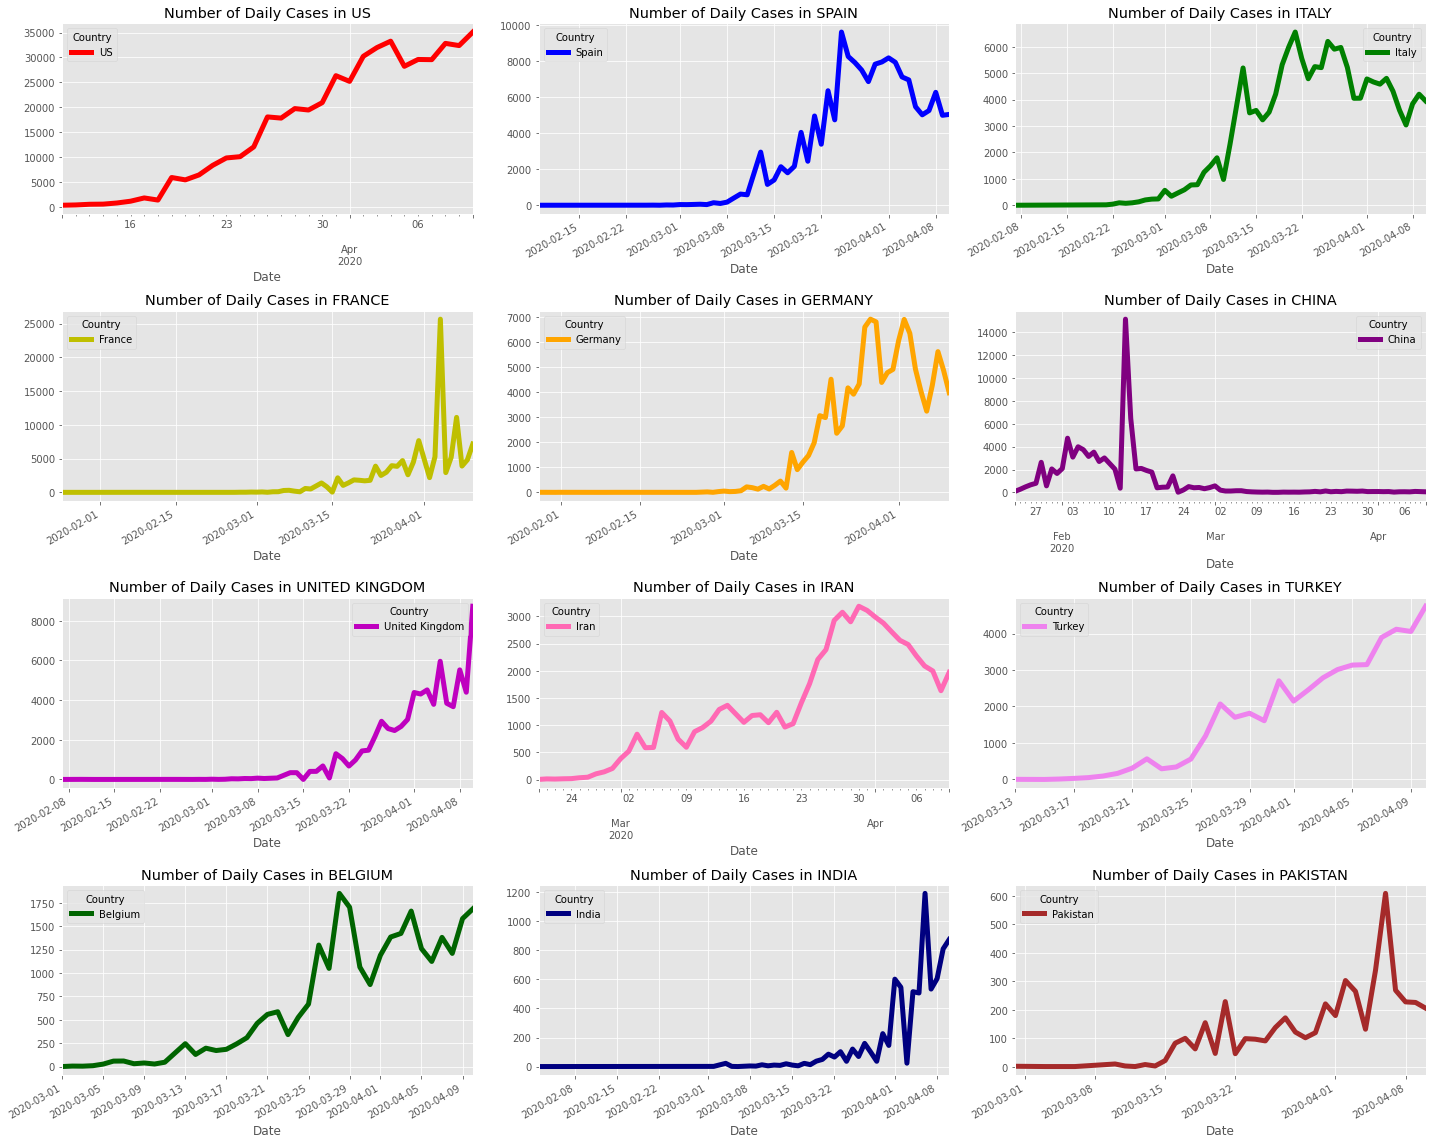

In [0]:
plt.figure(figsize=(20,16))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Confirm=Confirm_pivot[Confirm_pivot[country]>0][country].diff().fillna(0)
    Confirm=Confirm[Confirm>0]
    
    plt.subplot(4,3,i+1)
    Confirm.plot(color=colors[i],label=country,markersize=12,lw=5)    
    plt.xticks()
    plt.legend(title='Country')
    plt.title('Number of Daily Cases in {}'.format(country.upper()))
plt.tight_layout()

In [0]:
coun = []
maxi= []
id_m= []

for country in list_countries:
    id_max=Confirm_pivot[country].diff().fillna(0).idxmax()
    maxim=Confirm_pivot[country].diff().fillna(0).max()
    print('Maximum New Cases registered for {0} was {1} on {2}'.format(country,maxim,id_max))
    coun.append(country)
    maxi.append(maxim)
    id_m.append(id_max)

df_max_case = pd.DataFrame(list(zip(coun, maxi, id_m)), columns =['country', 'max_case', 'date']) 
df_max_case

df_max_case['date']=df_max_case['date'].astype(str)

Maximum New Cases registered for US was 35098.0 on 2020-04-10 00:00:00
Maximum New Cases registered for Spain was 9630.0 on 2020-03-25 00:00:00
Maximum New Cases registered for Italy was 6557.0 on 2020-03-21 00:00:00
Maximum New Cases registered for France was 25646.0 on 2020-04-04 00:00:00
Maximum New Cases registered for Germany was 6933.0 on 2020-03-27 00:00:00
Maximum New Cases registered for China was 15136.0 on 2020-02-13 00:00:00
Maximum New Cases registered for United Kingdom was 8733.0 on 2020-04-10 00:00:00
Maximum New Cases registered for Iran was 3186.0 on 2020-03-30 00:00:00
Maximum New Cases registered for Turkey was 4747.0 on 2020-04-10 00:00:00
Maximum New Cases registered for Belgium was 1850.0 on 2020-03-28 00:00:00
Maximum New Cases registered for India was 1190.0 on 2020-04-06 00:00:00
Maximum New Cases registered for Pakistan was 609.0 on 2020-04-06 00:00:00


In [0]:
fig = px.bar(df_max_case, x=df_max_case.country, y='max_case', text = 'date',
             labels={'x':'country'}, color="country", 
             color_continuous_scale=px.colors.sequential.Rainbow_r)
fig.update_layout(title_text='Date on which a top 12 countries had Maximum cases')
fig.show()

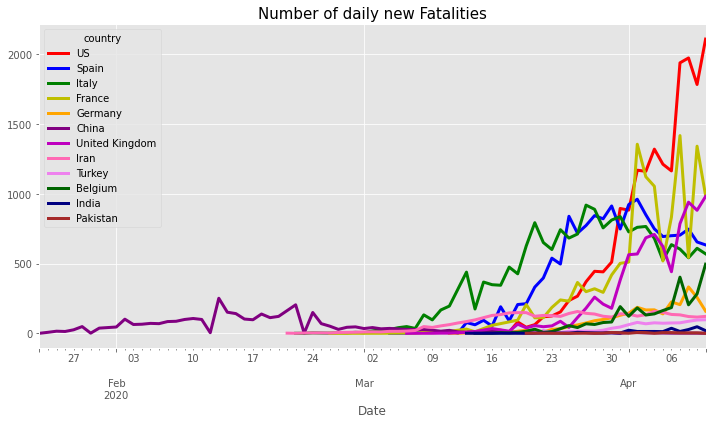

In [0]:
Fatal_pivot=pd.pivot_table(train_df,index='Date',
                           columns='Country_Region',
                           values='Fatalities',
                           aggfunc=np.sum)

plt.figure(figsize=(10,6))
colors=['r','b','g','y','orange','purple','m','hotpink','violet','darkgreen','navy','brown']
for i,country in enumerate(list_countries):
    Fatal_diff=Fatal_pivot[Fatal_pivot[country]>0][country].diff().fillna(0)
    Fatal_diff=Fatal_diff[Fatal_diff>0]
    Fatal_diff.plot(color=colors[i],label=country,markersize=8,lw=3)   
    plt.title('Number of daily new Fatalities',fontsize=15)
    plt.legend(title='country')
plt.tight_layout()

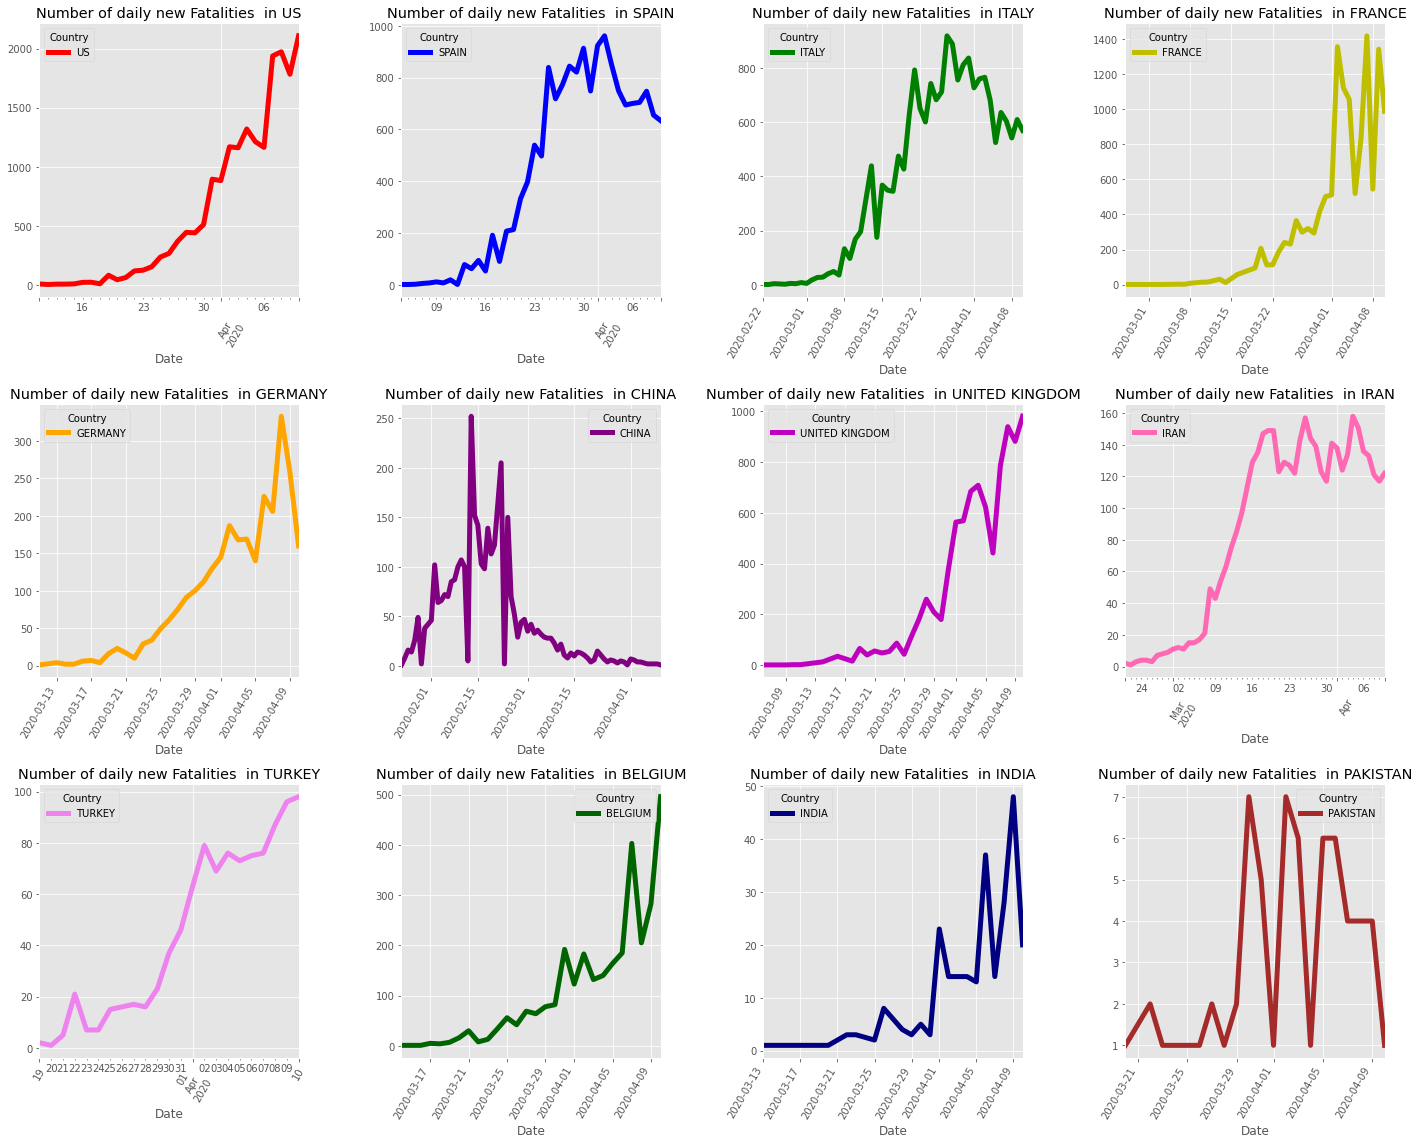

In [0]:
plt.figure(figsize=(20,16))
for i,country in enumerate(list_countries):
    Fatal_diff=Fatal_pivot[(Fatal_pivot[country]>0)][country].diff().fillna(0)
    Fatal_diff=Fatal_diff[Fatal_diff>0]
    plt.subplot(3,4,i+1)
    Fatal_diff.plot(color=colors[i],label=country.upper(),lw=5)
    plt.xticks(rotation=60)
    plt.title('Number of daily new Fatalities  in {}'.format(country.upper()))
    plt.legend(title='Country')
plt.tight_layout()

### Prediction

In [0]:
test_df['Date']=pd.to_datetime(test_df['Date'])
test_df

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06
...,...,...,...,...
13454,13455,NaN,Zimbabwe,2020-05-10
13455,13456,NaN,Zimbabwe,2020-05-11
13456,13457,NaN,Zimbabwe,2020-05-12
13457,13458,NaN,Zimbabwe,2020-05-13


In [0]:
test_df['Province_State']=test_df.drop('Province_State',axis=1)
train_df=train_df.reset_index()

from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()

train_df['Country_Region']=LE.fit_transform(train_df['Country_Region'])
test_df['Country_Region']=LE.transform(test_df['Country_Region'])

train_df.loc[:, 'Date'] = train_df.Date.dt.strftime("%m%d")
train_df["Date"]  = train_df["Date"].astype(int)

test_df.loc[:, 'Date'] = test_df.Date.dt.strftime("%m%d")
test_df["Date"]  = test_df["Date"].astype(int)

In [0]:
#Select feature column names and target variable we are going to use for training
features=['Date','Country_Region']
target = 'ConfirmedCases'

#This is input which our classifier will use as an input.
train_df[features].head(10)

,Date,Country_Region
0,122,0
1,123,0
2,124,0
3,125,0
4,126,0
5,127,0
6,128,0
7,129,0
8,130,0
9,131,0


In [0]:
from sklearn.ensemble import RandomForestClassifier

# We define the model
rfcla = RandomForestClassifier(n_estimators=20, max_samples=0.8,
                        random_state=1)
# We train model
rfcla.fit(train_df[features],train_df[target])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [0]:
#Make predictions using the features from the test data set
predictions = rfcla.predict(test_df[features])

predictions

array([273., 281., 299., ...,  13.,  13.,  13.])

In [0]:
target2='Fatalities'

# We define the model
rfcla2 = RandomForestClassifier(n_estimators=20, max_samples=0.8,
                        random_state=1)
# We train model
rfcla2.fit(train_df[features],train_df[target2])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [0]:
#Make predictions using the features from the test data set
predictions2 = rfcla2.predict(test_df[features])

print(predictions2[0:500])

[  6.   6.   7.   7.  11.  14.  14.  15.  15.  15.  15.  15.  15.  15.
  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.  15.
  15.  16.  17.  20.  20.  21.  22.  22.  23.  23.  23.  23.  23.  23.
  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.
  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.
  23.  23.  86. 105. 130. 152. 173. 193. 205. 235. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256.  15.  16.  17.  18.  21.  22.  23.  25.  26.  26.  26.
  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.
  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.  26.
  26.  26.  26.  26.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   2. 

In [0]:
#Create a  DataFrame
submission = pd.DataFrame({'ForecastId':test_df['ForecastId'],'ConfirmedCases':predictions,'Fatalities':predictions2})
                        

#Visualize the first 10 rows
submission.head(10)

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0
5,6,423.0,14.0
6,7,444.0,14.0
7,8,484.0,15.0
8,9,521.0,15.0
9,10,521.0,15.0


In [0]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'submission.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submission.csv
